In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import betaprime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
sns.set_context("talk", font_scale=.5)

In [2]:
from collections import namedtuple

Card = namedtuple('Card', ['value', 'suit'])
suits = ['hearts', 'diamonds', 'spades', 'clubs']
cards = [Card(value, suit) for value in range(1, 14) for suit in suits] #created class of type 'cards'

In [3]:
#alpha = [Jacks_P1, Total_Jacks_P1, Jacks_P2, Total_Jacks_P2]
#beta  = [len(Player_1),len(Player_2),miracle1, miracle2]

def Janken_V3(alpha, beta, bias):

    Psize    = 52-beta[0]-beta[1]-beta[2]  # beta 0 and 1 contains the size of the two player's decks
    
    #Player one variables
    Miracle1 = beta[2]
    Cjacks1 = alpha[0]
    Tjacks1 = alpha[1]
    Dsize1  = beta[0]
    
    
    # Player two Variables 
    Miracle2 = beta[3]
    Cjacks2 = alpha[2]
    Tjacks2 = alpha[3]
    Dsize2  = beta[1]

    
    #Player one sampling scheme 
    alp1    = 1 + (Dsize1+Psize)//52
    bet1    = Cjacks1*Tjacks1 + Miracle1 + 1/(1 + (Miracle1))  #reacting time simulation: "Magic line"
    params1 = [alp1, bet1]
    absol1  = [random.gammavariate(a, 1+Miracle1) for a in params1]
    absol1  = [v / sum(absol1) for v in absol1] #normalizing them! 
 
    
    alp2    = 1 + (Dsize2+Psize)//52 #reacting time simulation
    bet2    = Cjacks2*Tjacks2 + Miracle2 + 1/(1 + (Miracle2)) #Can never be zero; this is the location
    params2 = [alp2, bet2]
    absol2  = [random.gammavariate(a, 1+Miracle2) for a in params2]
    absol2  = [v / sum(absol2) for v in absol2] 
    
   

    if bias == True: #Need to fix in terms of random sampling probabilities for the game.
        absolp1  = np.max(absol1)
        absolp2  = np.min(absol2)
        prob1 = betaprime.pdf(alp1,bet1,absolp1)
        prob2 = betaprime.pdf(alp2,bet2,absolp2)
    else:
        absolp1  = np.max(absol1)
        absolp2  = np.max(absol2)
        prob1 = betaprime.pdf(alp1,bet1,absolp1)
        prob2 = betaprime.pdf(alp2,bet2,absolp2)

        
    return([prob1,prob2])

In [44]:
# Our Filtering Scheme 

def SlapJack(n,biased):
    random.shuffle(cards)
    Player_1 = cards[0:52:2]
    Player_2 = cards[1:52:2]
    val     = []
    Pile     = []
    i        = 1
    Jacks_P1 = 0
    Total_Jacks_P1 = 0
    Jacks_P2 = 0
    Total_Jacks_P2 = 0
    miracle1 = 0
    miracle2 = 0
    alpha = [Jacks_P1, Total_Jacks_P1, Jacks_P2, Total_Jacks_P2] #nuisanced parameters representing the "hotnes"
    beta  = [len(Player_1),len(Player_2),miracle1,miracle2] # Same as above, but these are passed to Janken
    flag = False #Tells the foreloop how long to keep going
    bias = biased #baised the location of destribution where players sample from 
    
 
    while flag == False:
        if len(Player_1) != 0 and len(Player_2) != 0:
            a1 = Player_1[0]
            a2 = Player_2[0]
            Pile.append(a1)
            Pile.append(a2)
            Player_1.pop(0)
            Player_2.pop(0)

            if a1[0] == 11 or a2[0] == 11 or a1[0] == 1 or a2[0] == 1:
                # Alpha = {Cjacks1, Tjacks1, Cjacks2, Tjacks2}
                # Beta  = {Dsize1, Dsize2, miracle1, miracle2}

                probs = Janken_V3(alpha,beta,bias)
                prob1 = probs[0]
                prob2 = probs[1]

                if prob1 > prob2:
                    Player_1.extend(Pile)
                    #random.shuffle(Player_1)
                    Jacks_P1 +=1
                    Total_Jacks_P1 +=1
                    Jacks_P2 = 0
                    i += 1
                    val.append(1) #Instead of appending winner of round, we instead do the amount of cards in pile 
                    Pile = []
                    
                elif prob2 > prob1:
                    Player_2.extend(Pile)
                    #random.shuffle(Player_2)
                    Jacks_P2 +=1
                    Total_Jacks_P2 +=1
                    Jacks_P1 = 0
                    i += 1
                    val.append(2)
                    Pile = []
            else:
                #print("Current Round:"+ str(i))
                #print("Player 2's deck size: " + str(len(Player_2)))
                #print("Player 1's deck size: " + str(len(Player_1)))
                #print("Pile size: " + str(len(Pile)))
                #print("The current Miracles (M1,M2): " + str((miracle1,miracle2)))
                #print ('\n')
                i += 1

        if len(Player_1) == 0 or len(Player_2) == 0.:
            probs = Janken_V3(alpha,beta,bias)
            prob1 = probs[0]
            prob2 = probs[1]

            if len(Player_2) == 0 and prob2 > prob1:
                Pile.append(Player_1[0])
                Player_1.pop(0)
                Player_2.extend(Pile)
                #random.shuffle(Player_2)
                Pile = []
                miracle2 += 1
            elif len(Player_1) == 0. and prob1 > prob2:
                Pile.append(Player_2[0])
                Player_2.pop(0)
                Player_1.extend(Pile)
                #random.shuffle(Player_1)
                Pile = []
                miracle1 += 1
            elif len(Player_1) == 0. and prob2 > prob1:
                flag = True
                val.append(miracle2)
                val.append(0)
                val.append(i)
                return np.array(val)

            elif len(Player_2) == 0. and prob1 > prob2:
                flag = True
                val.append(miracle1)
                val.append(1)
                val.append(i)
                return np.array(val)
            i +=1

        if i == n:
            return np.array([]) #no one won during this time\n",
            #print("No won has won during the alloted time frame of: " + str(n) +" turns")
            break

In [33]:


# Functions for ploting 
#Parameters = [nsample, cluster, cluster_std, random_tate, mix_comp]
def clustering(varbs):
    
    X = [(varbs[0][i],varbs[1][i]) for i in range(0,len(varbs[0]))]
    
    #Our data using the blob_function. 
    data = pd.DataFrame(X)
    data.columns=["X1","X2"]
    #data["cluster"]=y
    data.head()
    
    # visualize and save our data
    title = "Simulated data"
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=data, x="X1",y="X2")
    plt.title(title,fontsize=17)
    plt.ylabel("Wavelength",fontsize =13)
    plt.xlabel("Wavelength",fontsize =13)  
    plt.legend()
#    plt.savefig("Data_for_fitting_Gaussian_Mixture_Models.png",format='png',dpi=150)
    
    #Making our model
    mix_comp = varbs[2]
    gmm = GaussianMixture(mix_comp, covariance_type='full', random_state = 0).fit(data[["X1","X2"]])
    print("The locations of the means of our mixture models are at: " +str(gmm.means_))
    
    #labeling the model observables. 
    labels = gmm.predict(data[["X1","X2"]])
    data["predicted_cluster"]=labels
    
    
    title = "Mixture model with "+ str(mix_comp) + " components"
    plt.figure(figsize=(7,7))
    sns.scatterplot(data=data, x="X1",y="X2", palette="deep", hue="predicted_cluster",)
    sns.scatterplot(gmm.means_[:,0],gmm.means_[:,1],color='orange',marker='^')
    plt.title(title,fontsize=17)
    plt.legend()
    plt.ylabel("Wavelength", fontsize =13)
    plt.xlabel("Wavelength",fontsize =13)  
    #   plt.savefig("Fitting_Gaussian_Mixture_Models_with_components.png",format='png',dpi=150)
    return(gmm.means_)


def lenght(X,mix_comp):
    for i in range(0,mix_comp):
        print(np.sqrt(X[i][0]**2+X[i][0]**2))

In [45]:
#Our Simulation
Nexp = 1000
Nlimit = 100000
biased = False

Expm = [SlapJack(Nlimit,biased) for t in range(0,Nexp)] 
Expm = np.array(Expm)

<ipython-input-45-cd0ac771df88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Expm = np.array(Expm)


In [ ]:
#each game has no fixed end round. 
print(len(Expm)) #Number of games played 
print(len(Expm[0])) # number of rounds played per some game
print(Expm[:10])
#It has the winners of the round; the last three entries of the lists are: miracles, winner of game, round #
print(Expm[0][-3:])

In [46]:
#Organizing the data. We retrieve our filtering events 
%%capture
multi_verse_1   = []
multi_verse_2   = []

multi_verse_1_1   = []
multi_verse_2_1   = []

for i in range(0,Nexp):
    Miracle, Winner, Round = Expm[i][-3:]
    zeroth = np.where(Expm[i][:-3] == 1)[0] 
    multi_verse_1.append(len(zeroth))      #find this winner labled "0"
#    Expm_resuls = sum(Expm[i][:-3])        
#    multi_verse_2.append(Expm_resuls)
    
    
for i in range(0,Nexp):
    Miracle, Winner, Round = Expm[i][-3:]
    zeroth = np.where(Expm[i][:-3] == 2)[0] 
    multi_verse_2.append(len(zeroth))      #find this winner labled "1"
#    Expm_resuls = sum(Expm[i][:-3])        
#    multi_verse_2_1.append(Expm_resuls)
    

No handles with labels found to put in legend.
C:\Users\nf238\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The locations of the means of our mixture models are at: [[12.33322797 12.20300061]
 [33.35085974 33.76676723]]
17.44181826943182
47.16523816007465


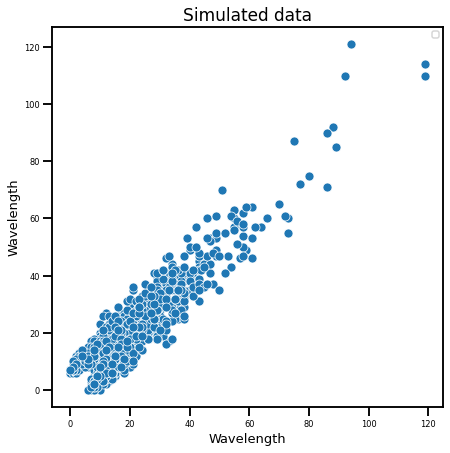

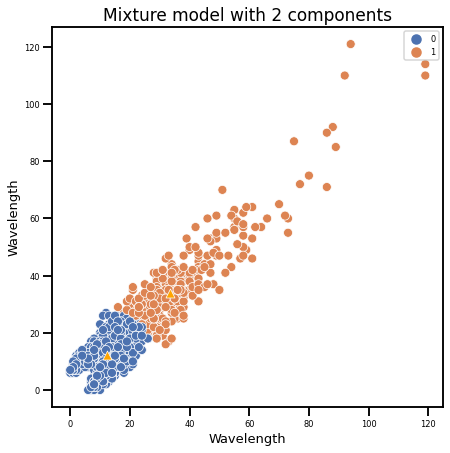

In [53]:
#Modeling the data
mix_comp     = 2

multi_verse_1 = np.array(multi_verse_1)
multi_verse_1_1 = np.array(multi_verse_2)

params_1 = [multi_verse_1, multi_verse_2, mix_comp]
X_1 = clustering(params_1)

lenght(X_1,mix_comp)

No handles with labels found to put in legend.
C:\Users\nf238\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The locations of the means of our mixture models are at: [[11.16727405  5.46892866]
 [39.05361353 40.0792928 ]
 [21.7084503  21.54046573]
 [88.60768153 89.82808879]
 [54.60441175 54.64341536]
 [ 5.3238661  10.99968147]
 [14.47205317 14.29651055]
 [30.25492318 31.60582026]]
15.792910415087857
55.23014990726293
30.700384828595695
125.31018494848627
77.22229966753538
7.52908364298677
20.466573861599823
42.786922695676196


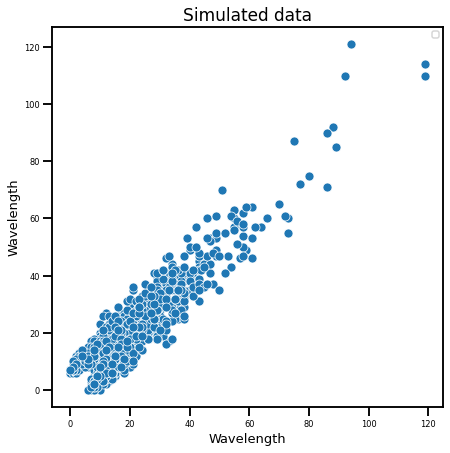

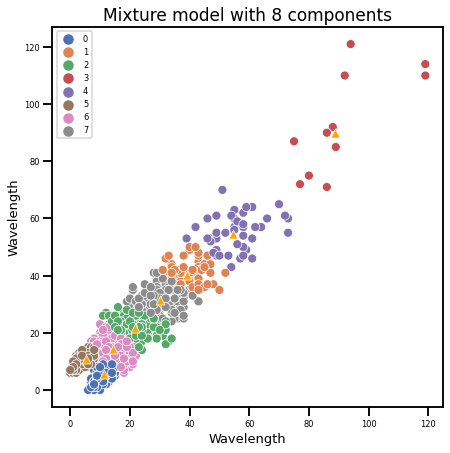

In [54]:
mix_comp     = 8

multi_verse_1 = np.array(multi_verse_1)
multi_verse_1_1 = np.array(multi_verse_2)

params_1 = [multi_verse_1, multi_verse_2, mix_comp]
X_1 = clustering(params_1)

lenght(X_1,mix_comp)